In [1]:
import sys
import datetime
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt

if not '..' in sys.path:
    sys.path.append('..')
from train_LSTM import *

In [2]:
def show_plot(plot_data, delta, title):
    create_time_steps = lambda length: list(range(-length, 0))
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rs', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    future = np.array(delta)

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=8, markerfacecolor='w',
                     markeredgewidth=2, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future.max()+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [3]:
time_step = 15 # [minutes]
data = pickle.load(open('../data/data1.pkl', 'rb'))
df = data['full']['building_energy']

orig_time_step = extract_time_step(df)
df = add_minute_and_workday(df)
df = average_data(df, time_step, orig_time_step, ['consumption', 'generation'])
n_days, samples_per_day = compute_stats(df, time_step)
t = np.arange(samples_per_day) * time_step / 60

print(f'Time step: {time_step} minutes.')
print(f'Number of days: {n_days}.')
print(f'Samples per day: {samples_per_day}.')

Time step: 15 minutes.
Number of days: 365.
Samples per day: 96.


(25856640.0, 25859520.0)

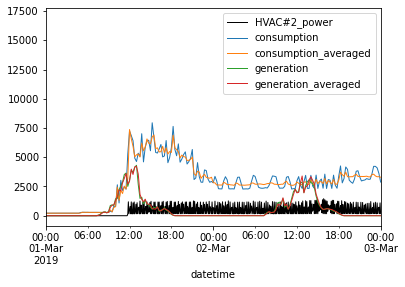

In [4]:
fig,ax = plt.subplots(1, 1)
data['full']['zones'][2].plot(x='datetime', y='HVAC#2_power', color='k', lw=1, ax=ax)
df.plot(x='datetime', y=['consumption','consumption_averaged','generation','generation_averaged'], lw=1, ax=ax)
start = pd.Timestamp(year=2019, month=3, day=1)
stop = pd.Timestamp(year=2019, month=3, day=3)
# plt.ylim([-100,6000])
ax.set_xlim([start,stop])

In [5]:
df.head()

,datetime,consumption_averaged,generation_averaged,weekday,weekend,holiday,consumption,generation,minute,workday
2,2019-01-01 00:15:00,2503.000000,0.0,1,False,True,2266,0,15,False
5,2019-01-01 00:30:00,2511.333333,0.0,1,False,True,2253,0,30,False
8,2019-01-01 00:45:00,2488.000000,0.0,1,False,True,2249,0,45,False
11,2019-01-01 01:00:00,2488.333333,0.0,1,False,True,2251,0,60,False
14,2019-01-01 01:15:00,2467.000000,0.0,1,False,True,2250,0,75,False


In [6]:
n_days_training = int(0.8 * n_days)
n_days_validation = int(0.1 * n_days)
n_days_test = n_days - n_days_training - n_days_validation
TRAIN_SPLIT = n_days_training * samples_per_day
VALIDATION_SPLIT = (n_days_training + n_days_validation) * samples_per_day
print('We will use the first {} measurements (corresponding to {} days) to train the network.'.\
      format(TRAIN_SPLIT, n_days_training))
print('We will use the subsequent {} measurements (corresponding to {} days) to validate the network.'.\
      format(VALIDATION_SPLIT - TRAIN_SPLIT, n_days_validation))
print('We will use the final {} measurements (corresponding to {} days) to validate the network.'.\
      format(n_days_test * samples_per_day, n_days_test))

We will use the first 28032 measurements (corresponding to 292 days) to train the network.
We will use the subsequent 3456 measurements (corresponding to 36 days) to validate the network.
We will use the final 3552 measurements (corresponding to 37 days) to validate the network.


In [7]:
cols_continuous = ['consumption_averaged','generation_averaged']
cols_categorical = ['minute','weekday','workday']

cols_idx = [df.columns.get_loc(col) for col in cols_continuous]
x_train_max = df.iloc[:TRAIN_SPLIT, cols_idx].max().to_numpy(dtype=np.float32)
x_train_min = df.iloc[:TRAIN_SPLIT, cols_idx].min().to_numpy(dtype=np.float32)

X = make_dataset(df, cols_continuous, cols_categorical,
                x_train_max, x_train_min, n_days, samples_per_day)

In [8]:
# length of history to use for prediction
history_size = int(samples_per_day / 1)
# how many steps to predict in the future
target_size = 1 * 60 // time_step
# how many steps to look ahead
steps_ahead = 0

x_train, y_train = make_data_blocks(X, 0, TRAIN_SPLIT, history_size, target_size,
                                    steps_ahead, target=X[:,0])
x_val,   y_val   = make_data_blocks(X, TRAIN_SPLIT, VALIDATION_SPLIT, history_size,
                                    target_size, steps_ahead, target=X[:,0])
x_test,  y_test  = make_data_blocks(X, VALIDATION_SPLIT, None, history_size,
                                    target_size, steps_ahead, target=X[:,0])

In [9]:
x_train.shape

(27936, 96, 107)

In [10]:
y_train.shape

(27936, 4)

<module 'matplotlib.pyplot' from '/home/daniele/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

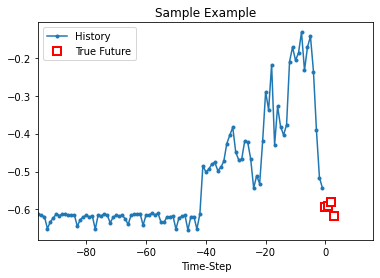

In [11]:
i = 170
show_plot([x_train[i, :, 0], y_train[i]], np.arange(target_size), 'Sample Example')

In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [13]:
n_layers = 3
n_units = [15 for _ in range(n_layers)]

inputs = tf.keras.Input(shape=x_train.shape[-2:], name='input')
for n in n_units[:-1]:
    try:
        lyr = tf.keras.layers.LSTM(n, return_sequences=True)(lyr)
    except:
        lyr = tf.keras.layers.LSTM(n, return_sequences=True)(inputs)
try:
    lyr = tf.keras.layers.LSTM(n_units[-1])(lyr)
except:
    lyr = tf.keras.layers.LSTM(n_units[-1])(inputs)
outputs = tf.keras.layers.Dense(target_size)(lyr)

RNN = tf.keras.Model(inputs=inputs, outputs=outputs)

RNN.compile(optimizer='adam', loss='mae')
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 107)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96, 15)            7380      
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 15)            1860      
_________________________________________________________________
lstm_3 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense (Dense)                (None, 4)                 64        
Total params: 11,164
Trainable params: 11,164
Non-trainable params: 0
_________________________________________________________________


In [14]:
EVALUATION_INTERVAL = 100
EPOCHS = 5
history = RNN.fit(train, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val, validation_steps=50)

Epoch 1/5
100/100 [==============================] - 57s 510ms/step - loss: 0.2241 - val_loss: 0.1557
Epoch 2/5
100/100 [==============================] - 146s 1s/step - loss: 0.0746 - val_loss: 0.1268
Epoch 3/5
100/100 [==============================] - 57s 565ms/step - loss: 0.0617 - val_loss: 0.0846
Epoch 4/5
100/100 [==============================] - 57s 572ms/step - loss: 0.0543 - val_loss: 0.0619
Epoch 5/5
100/100 [==============================] - 50s 496ms/step - loss: 0.0518 - val_loss: 0.0509


In [15]:
train_loss = RNN.evaluate(x_train, y_train, verbose=0)
val_loss   = RNN.evaluate(x_val,   y_val,   verbose=0)
test_loss  = RNN.evaluate(x_test,  y_test,  verbose=0)
print('Loss on the training set ..... {:.4f}.'.format(train_loss))
print('Loss on the validation set ... {:.4f}.'.format(val_loss))
print('Loss on the test set ......... {:.4f}.'.format(test_loss))

Loss on the training set ..... 0.0519.
Loss on the validation set ... 0.0514.
Loss on the test set ......... 0.0804.


In [16]:
test_prediction = RNN.predict(x_test)
val_prediction = RNN.predict(x_val)
days_test = np.arange(y_test.shape[0]) / samples_per_day
days_val = np.arange(y_val.shape[0]) / samples_per_day

<module 'matplotlib.pyplot' from '/home/daniele/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

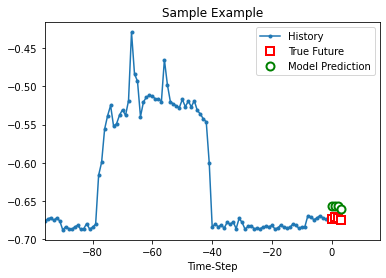

In [17]:
i = 3000
y_pred = RNN.predict(x_test[i:i+1, :, :]).squeeze()
show_plot([x_test[i, :, 0], y_test[i], y_pred], np.arange(target_size), 'Sample Example')

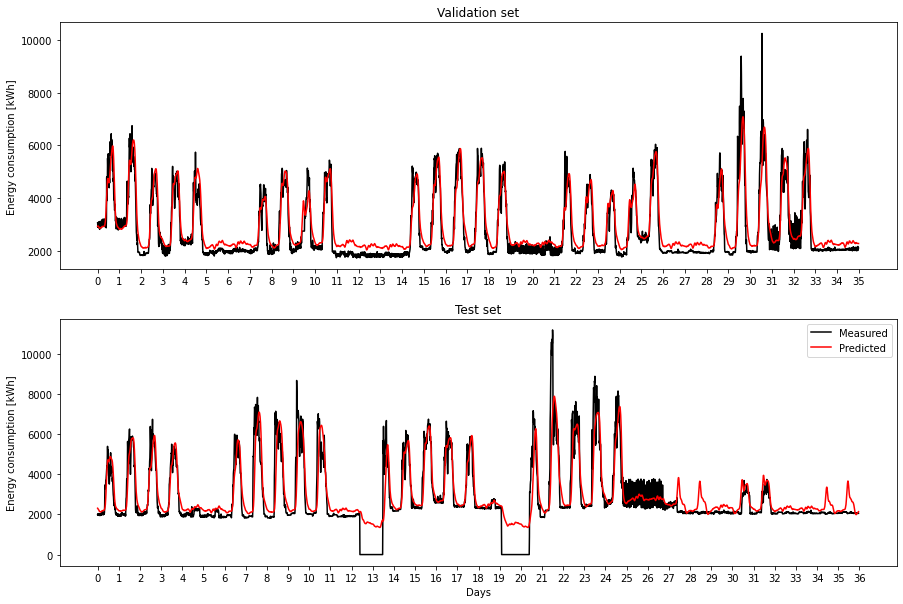

In [18]:
fun = lambda y,M,m: m + (M - m) / 2 * (y + 1)

i = 0
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.plot(days_val, fun(y_val[:,i], x_train_max[0], x_train_min[0]), 'k', label='Measured')
ax1.plot(days_val, fun(val_prediction[:,i], x_train_max[0], x_train_min[0]), 'r', label='Predicted')
ax1.set_title('Validation set')
ax1.set_ylabel('Energy consumption [kWh]')
ax1.set_xticks(np.arange(int(np.ceil(days_val[-1])) + 1))

ax2.plot(days_test, fun(y_test[:,i], x_train_max[0], x_train_min[0]), 'k', label='Measured')
ax2.plot(days_test, fun(test_prediction[:,i], x_train_max[0], x_train_min[0]), 'r', label='Predicted')
ax2.set_title('Test set')
ax2.set_xlabel('Days')
ax2.set_ylabel('Energy consumption [kWh]')
ax2.legend(loc='best')
# ax2.set_xlim([6, 8])
ax2.set_xticks(np.arange(int(np.ceil(days_test[-1])) + 1));